### Machine Learning Engineer Capstone Project 

## Project: Dog Identification App 

In this notebook, I will develop an algorithm to estimate the dog's breed. This algorithm will be composed of a dog detector and a human detector. If a dog is detected in the input image, it will provide an estimate of the dog's breed. If a human is detected, it will provide an estimate of the dog breed that is most similar.

### Roadmap

* [First](#step1):  Import Datasets 
* [Second](#step2): Transform the data
* [Third](#step3):  Upload to S3
* [Fourth](#step4):  Implement dog detector
* [Fifth](#step5): Implement the human face detector
* [Sixth](#step6):  Implement dog breed estimator

<a id='step1'></a>

## 1<sup>st</sup>: Import datasets

The datasets that I will use are obtained from:
* [Standford database for dog breeds images](http://vision.stanford.edu/aditya86/ImageNetDogs) dataset from kaggle competition
* the human images from "[Labeled Faced in the Wild](http://vis-www.cs.umass.edu/lfw/)".

First import all libraries that we need

In [3]:
import numpy as np

from glob import glob
import os
import shutil
import ntpath
from PIL import Image
from sklearn.datasets import load_files  


import torchvision.models as models

import cv2
import matplotlib.pyplot as plt


import torch
import torchvision
import torch.nn as nn
from torchvision import datasets
import torchvision.transforms as transforms
import torch.optim as optim

For dog-breed dataset, I will download the file from stanford site. The zip file will be upload to the jupiter notebook repository and then I must unzip the file. For each image, there are two files the image file and the annotation file, which contains a description of the image. We'll need this file for the dog detector.

In [ ]:
!wget http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar

--2020-02-02 16:00:18--  http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar
Resolving vision.stanford.edu (vision.stanford.edu)... 171.64.68.10
Connecting to vision.stanford.edu (vision.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 793579520 (757M) [application/x-tar]
Saving to: ‘images.tar’

images.tar           35%[======>             ] 265.58M  67.0MB/s    eta 10s    

Now we make the directories that we need to transform the data and divide it into train and validation data. We also decompress the data.

In [5]:
!mkdir dogs_data
!mkdir dogs_data/train
!mkdir dogs_data/validation
!mkdir dogs_data/test
!tar -xf images.tar -C dogs_data/

dog_files = np.array(glob("./dogs_data/Images/*/*"))

print('There are %d total dog images.' % len(dog_files))

There are 20580 total dog images.


For the Human datasets, I will use the "Labeled Faced in the Wild" dataset. And We'll make the directory structure for it.

In [12]:
!wget http://vis-www.cs.umass.edu/lfw/lfw.tgz

--2020-02-02 14:40:42--  http://vis-www.cs.umass.edu/lfw/lfw.tgz
Resolving vis-www.cs.umass.edu (vis-www.cs.umass.edu)... 128.119.244.95
Connecting to vis-www.cs.umass.edu (vis-www.cs.umass.edu)|128.119.244.95|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 180566744 (172M) [application/x-gzip]
Saving to: ‘lfw.tgz’

lfw.tgz             100%[===================>] 172.20M   176KB/s    in 22m 48s 

2020-02-02 15:03:31 (129 KB/s) - ‘lfw.tgz’ saved [180566744/180566744]



In [6]:
!mkdir face_data
!tar -zxf lfw.tgz -C face_data/

human_files = np.array(glob("./face_data/lfw/*/*"))

print('There are %d total human images.' % len(human_files))

There are 13233 total human images.


In [7]:
!rm ./images.tar
!rm ./lfw.tgz

In [4]:

dog_files = np.array(glob("./dogs_data/*/*/*"))

print('There are %d total dog images.' % len(dog_files))

human_files = np.array(glob("./face_data/lfw/*/*"))

print('There are %d total human images.' % len(human_files))

There are 20580 total dog images.
There are 13233 total human images.


<a id='step2'></a>
## 2<sup>nd</sup>: Transform the data

In this section, we will transform the dog dataset and the face dataset. We need making several files that sagemaker use to construct the model.

### Dog Data

I

In [5]:
for directory in os.listdir('./dogs_data/Images'): 
    dogs_dir = './dogs_data/Images/'+directory
    if os.path.isdir(dogs_dir):
        dogs = np.array(glob(dogs_dir+'/*'))
        train_index=round(len(dogs)*.7)
        valid_index=round(len(dogs)*.85)
        train = dogs[:train_index]
        valid = dogs[train_index:valid_index]
        test = dogs[valid_index:]       
        os.makedirs('./dogs_data/train/'+directory)
        os.makedirs('./dogs_data/validation/'+directory)
        os.makedirs('./dogs_data/test/'+directory)
        for dog_train in train:
            file = ntpath.basename(dog_train)
            shutil.move(dogs_dir+'/'+file, './dogs_data/train/'+directory+'/'+file)
        for dog_valid in valid:
            file = ntpath.basename(dog_valid)
            shutil.move(dogs_dir+'/'+file, './dogs_data/validation/'+directory+'/'+file)
        for dog_test in test:
            file = ntpath.basename(dog_test)
            shutil.move(dogs_dir+'/'+file, './dogs_data/test/'+directory+'/'+file)
        os.rmdir(dogs_dir)

W

In [6]:
# convert BGR image to grayscale
def convertToRGB(img): 
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# extract pre-trained face detector
human_face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')


Test the imagen detector

Number of faces detected: 1


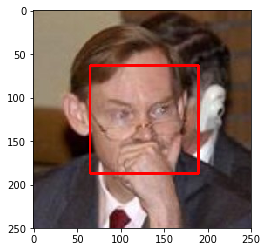

In [7]:
human_files = np.array(glob("./face_data/lfw/*/*"))

def test_face_detector_on_image(img, face_detector):
    
    gray = convertToRGB(img)
    #detect faces
    faces = face_detector.detectMultiScale(gray)

    print('Number of faces detected:', len(faces))

    for (x,y,w,h) in faces:
        cv2.rectangle(img,(x,y-4),(x+w+4,y+h),(0,0,255),2)

    # convert BGR image to RGB for plotting
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # plot image
    plt.imshow(cv_rgb)
    plt.show()

img = cv2.imread(human_files[18])
test_face_detector_on_image(img, human_face_cascade)

In [8]:
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = convertToRGB(img)
    faces = human_face_cascade.detectMultiScale(gray)
    return len(faces) > 0

Implement a human detector

In [9]:
human_files_short = human_files[:100]
train_files = np.array(glob("./dogs_data/train/*/*"))
dog_files_short = train_files[:100]

#test the detector
detected_faces_in_humans = 0
detected_faces_in_dogs = 0

for i in range(100):
    if face_detector(human_files_short[i]):
        detected_faces_in_humans += 1
    if face_detector(dog_files_short[i]):
        detected_faces_in_dogs +=1
        
print (f"Detected human faces: {detected_faces_in_humans}%")
print (f"Detected faces in dogs: {detected_faces_in_dogs}%")


Detected human faces: 100%
Detected faces in dogs: 5%


## Dog detector

For the dog detector we have used the pretrained Resnet50 network. The weights used were the standard ones for the dataset imagenet

In [10]:
# define ResNet50 model
dog_detector_model = models.vgg16(pretrained=True)

# move model to GPU if CUDA is available
if torch.cuda.is_available():
    dog_detector_model = dog_detector_model.cuda()

In [11]:
dog_detector_model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [14]:
def image_to_tensor(img_path):
    '''
    As per Pytorch documentations: All pre-trained models expect input images normalized in the same way, 
    i.e. mini-batches of 3-channel RGB images
    of shape (3 x H x W), where H and W are expected to be at least 224. 
    The images have to be loaded in to a range of [0, 1] and 
    then normalized using mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225]. 
    You can use the following transform to normalize:
    '''
    img = Image.open(img_path).convert('RGB')
    transformations = transforms.Compose([transforms.Resize(size=224),
                                          transforms.CenterCrop((224,224)),
                                         transforms.ToTensor(),
                                         transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                              std=[0.229, 0.224, 0.225])])
    image_tensor = transformations(img)[:3,:,:].unsqueeze(0)
    return image_tensor

In [15]:
test_tensor = image_to_tensor('./dogs_data/train/n02085620-Chihuahua/n02085620_1271.jpg')
#print(test_tensor)
print(test_tensor.shape)

torch.Size([1, 3, 224, 224])


In [16]:
def dog_detector_predict(img_path):
    image_tensor = image_to_tensor(img_path)
   
    # move model inputs to cuda, if GPU available
    if torch.cuda.is_available():
        image_tensor = image_tensor.cuda()

    # get sample outputs
    output = dog_detector_model(image_tensor)
    # convert output probabilities to predicted class
    _, preds_tensor = torch.max(output, 1)
    pred = np.squeeze(preds_tensor.numpy()) if not torch.cuda.is_available() else np.squeeze(preds_tensor.cpu().numpy())
 
    return int(pred)

In [17]:
print(dog_detector_predict('./dogs_data/train/n02085620-Chihuahua/n02085620_1271.jpg'))
print(dog_detector_predict(human_files_short[0]))

151
768


In [18]:
def dog_detector(img_path):    
    prediction = dog_detector_predict(img_path)
    return ((prediction >= 151) & (prediction <=268))

In [19]:
detected_dogs_in_humans = 0
detected_dogs_in_dogs = 0

for i in range(100):
    if dog_detector(human_files_short[i]):
        detected_dogs_in_humans += 1
        #human_dog_image = Image.open(human_files_short[i])
        #plt.imshow(human_dog_image)
        #plt.show()
    if dog_detector(dog_files_short[i]):
        detected_dogs_in_dogs +=1
        
print (f"Percentage of the images in human_files_short that have a detected dog: {detected_dogs_in_humans}%")
print (f"Percentage of the images in dog_files_short that have a detected dog: {detected_dogs_in_dogs}%")

Percentage of the images in human_files_short that have a detected dog: 2%
Percentage of the images in dog_files_short that have a detected dog: 99%


## Dog Classification

In [20]:
# convert data to a normalized torch.FloatTensor
transform = transforms.Compose([transforms.Resize(size=224),
                                transforms.CenterCrop((224,224)),
                                transforms.RandomHorizontalFlip(), # randomly flip and rotate
                                transforms.RandomRotation(10),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

# define training, test and validation data directories
data_dir = './dogs_data/'

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), transform)
                  for x in ['train', 'validation', 'test']}
loader = {
    x: torch.utils.data.DataLoader(image_datasets[x], shuffle=True, batch_size=8, num_workers=2)
    for x in ['train', 'validation', 'test']}

In [21]:
class_names = image_datasets['train'].classes
nb_classes = len(class_names)

class_names = [item[10:] for item in class_names]

print("Number of classes:", nb_classes)
print("\nClass names: \n\n", class_names)

Number of classes: 120

Class names: 

 ['Chihuahua', 'Japanese_spaniel', 'Maltese_dog', 'Pekinese', 'Shih-Tzu', 'Blenheim_spaniel', 'papillon', 'toy_terrier', 'Rhodesian_ridgeback', 'Afghan_hound', 'basset', 'beagle', 'bloodhound', 'bluetick', 'black-and-tan_coonhound', 'Walker_hound', 'English_foxhound', 'redbone', 'borzoi', 'Irish_wolfhound', 'Italian_greyhound', 'whippet', 'Ibizan_hound', 'Norwegian_elkhound', 'otterhound', 'Saluki', 'Scottish_deerhound', 'Weimaraner', 'Staffordshire_bullterrier', 'American_Staffordshire_terrier', 'Bedlington_terrier', 'Border_terrier', 'Kerry_blue_terrier', 'Irish_terrier', 'Norfolk_terrier', 'Norwich_terrier', 'Yorkshire_terrier', 'wire-haired_fox_terrier', 'Lakeland_terrier', 'Sealyham_terrier', 'Airedale', 'cairn', 'Australian_terrier', 'Dandie_Dinmont', 'Boston_bull', 'miniature_schnauzer', 'giant_schnauzer', 'standard_schnauzer', 'Scotch_terrier', 'Tibetan_terrier', 'silky_terrier', 'soft-coated_wheaten_terrier', 'West_Highland_white_terrier'

In [22]:
model_transfer = models.resnet50(pretrained=True)

if torch.cuda.is_available():
    model_transfer = model_transfer.cuda()

In [23]:
model_transfer

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

dfa

In [24]:
for param in model_transfer.parameters():
    param.requires_grad = False
# Replace the last fully connected layer with a Linnear layer with 133 out features
model_transfer.fc = nn.Linear(2048, 120)
if torch.cuda.is_available():
    model_transfer = model_transfer.cuda()

In [25]:
criterion_transfer = nn.CrossEntropyLoss()
optimizer_transfer = optim.Adam(model_transfer.fc.parameters(), lr=0.001)

In [26]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss    
    valid_loss_min = 3.5 
    
    if os.path.exists(save_path):
        model.load_state_dict(torch.load(save_path))
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for data, target in loaders['train']:
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update training loss
            train_loss += loss.item()*data.size(0)
            
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        for data, target in loaders['validation']:
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
    
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # update average validation loss 
            valid_loss += loss.item()*data.size(0)
           
        # calculate average losses
        train_loss = train_loss/len(loaders['train'].dataset)
        valid_loss = valid_loss/len(loaders['validation'].dataset)
        
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        # save model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
    # return trained model
    return model

In [30]:
# train the model
model_transfer =  train(12, loader, model_transfer, optimizer_transfer, criterion_transfer, torch.cuda.is_available(), 'model_transfer.pt')

Epoch: 1 	Training Loss: 1.221951 	Validation Loss: 0.855731
Validation loss decreased (3.500000 --> 0.855731).  Saving model ...
Epoch: 2 	Training Loss: 1.138445 	Validation Loss: 0.871256
Epoch: 3 	Training Loss: 1.141818 	Validation Loss: 0.867040
Epoch: 4 	Training Loss: 1.097065 	Validation Loss: 0.848584
Validation loss decreased (0.855731 --> 0.848584).  Saving model ...
Epoch: 5 	Training Loss: 1.094585 	Validation Loss: 0.873527
Epoch: 6 	Training Loss: 1.108063 	Validation Loss: 0.996624
Epoch: 7 	Training Loss: 1.081499 	Validation Loss: 0.958075
Epoch: 8 	Training Loss: 1.046121 	Validation Loss: 1.042178
Epoch: 9 	Training Loss: 0.969330 	Validation Loss: 1.006883
Epoch: 10 	Training Loss: 1.028049 	Validation Loss: 1.022844
Epoch: 11 	Training Loss: 1.018081 	Validation Loss: 1.035360
Epoch: 12 	Training Loss: 1.007625 	Validation Loss: 1.062575


In [27]:
# load the model that got the best validation accuracy
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

In [28]:
from sklearn.metrics import f1_score

In [31]:
print(len(loader['train']))
for data, target in loader['train']:
    print(data.shape)
    print(target.shape)

1800
torch.Size([8, 3, 224, 224])
torch.Size([8])
torch.Size([8, 3, 224, 224])
torch.Size([8])
torch.Size([8, 3, 224, 224])
torch.Size([8])
torch.Size([8, 3, 224, 224])
torch.Size([8])
torch.Size([8, 3, 224, 224])
torch.Size([8])
torch.Size([8, 3, 224, 224])
torch.Size([8])
torch.Size([8, 3, 224, 224])
torch.Size([8])
torch.Size([8, 3, 224, 224])
torch.Size([8])
torch.Size([8, 3, 224, 224])
torch.Size([8])
torch.Size([8, 3, 224, 224])
torch.Size([8])
torch.Size([8, 3, 224, 224])
torch.Size([8])
torch.Size([8, 3, 224, 224])
torch.Size([8])
torch.Size([8, 3, 224, 224])
torch.Size([8])
torch.Size([8, 3, 224, 224])
torch.Size([8])
torch.Size([8, 3, 224, 224])
torch.Size([8])
torch.Size([8, 3, 224, 224])
torch.Size([8])
torch.Size([8, 3, 224, 224])
torch.Size([8])
torch.Size([8, 3, 224, 224])
torch.Size([8])
torch.Size([8, 3, 224, 224])
torch.Size([8])
torch.Size([8, 3, 224, 224])
torch.Size([8])
torch.Size([8, 3, 224, 224])
torch.Size([8])
torch.Size([8, 3, 224, 224])
torch.Size([8])
torch

In [34]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.
    metrix_f1_score = []
    
    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        
        # update average test loss 
        test_loss += loss.item()*data.size(0)
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        y_true = target.data.view_as(pred)
        metrix_f1_score.append(f1_score(y_true, pred, average="weighted"))
        correct += np.sum(np.squeeze(pred.eq(y_true)).cpu().numpy())
        total += data.size(0)
        # print testing statistics 
            
    # calculate average loss
    test_loss = test_loss/len(loaders['test'].dataset)
        
    # print test statistics 
    print('Testing Loss Average: {:.6f} '.format(test_loss))
    
    
    print(('\nMean of f1_score of all batches: {}')
          .format(sum(metrix_f1_score)/len(metrix_f1_score)))
    
    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

In [35]:
test(loader, model_transfer, criterion_transfer, torch.cuda.is_available())

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Mean of f1_score of all batches: 0.79595207253886
Testing Loss Average: 0.922258 

Test Accuracy: 79% (2455/3084)


In [41]:
def predict_breed_transfer(img_path):
    # load the image and return the predicted breed
    image_tensor = image_to_tensor(img_path)

    # move model inputs to cuda, if GPU available
    if torch.cuda.is_available():
        image_tensor = image_tensor.cuda()

    # get sample outputs
    output = model_transfer(image_tensor)
    # convert output probabilities to predicted class
    _, preds_tensor = torch.max(output, 1)
    pred = np.squeeze(preds_tensor.numpy()) if not torch.cuda.is_available() else np.squeeze(preds_tensor.cpu().numpy())
    
    return class_names[pred]

In [39]:
def display_image(img_path, title="Title"):
    image = Image.open(img_path)
    plt.title(title)
    plt.imshow(image)
    plt.show()

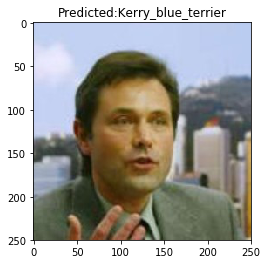

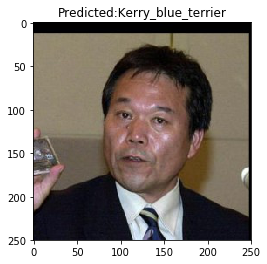

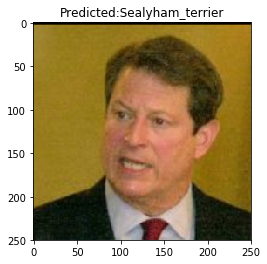

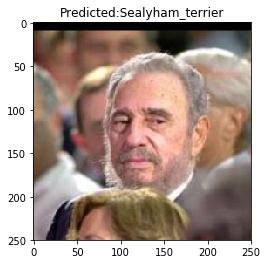

In [42]:
import random

# Try out the function
for image in random.sample(list(human_files_short), 4): 
    predicted_breed = predict_breed_transfer(image)
    display_image(image, title=f"Predicted:{predicted_breed}")

In [45]:
def run_app(img_path):
    # check if image has juman faces:
    if (face_detector(img_path)):
        print("Hello Human!")
        predicted_breed = predict_breed_transfer(img_path)
        display_image(img_path, title=f"Predicted:{predicted_breed}")
        
        print("You look like a ...")
        print(predicted_breed.upper())
    # check if image has dogs:
    elif dog_detector(img_path):
        print("Hello Doggie!")
        predicted_breed = predict_breed_transfer(img_path)
        display_image(img_path, title=f"Predicted:{predicted_breed}")
        
        print("Your breed is most likley ...")
        print(predicted_breed.upper())
    else:
        print("Oh, we're sorry! We couldn't detect any dog or human face in the image.")
        display_image(img_path, title="...")
        print("Try another!")
    print("\n")

Hello Human!


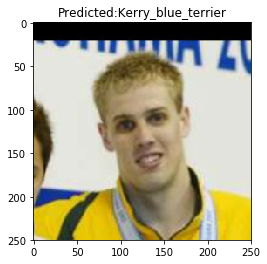

You look like a ...
KERRY_BLUE_TERRIER


Hello Human!


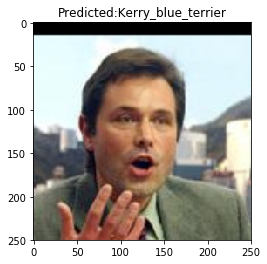

You look like a ...
KERRY_BLUE_TERRIER


Hello Human!


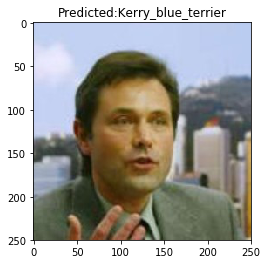

You look like a ...
KERRY_BLUE_TERRIER


Hello Doggie!


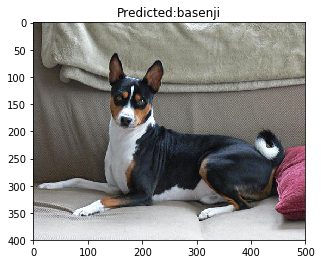

Your breed is most likley ...
BASENJI


Hello Doggie!


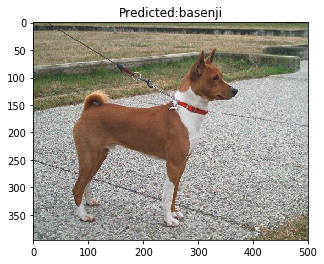

Your breed is most likley ...
BASENJI


Oh, we're sorry! We couldn't detect any dog or human face in the image.


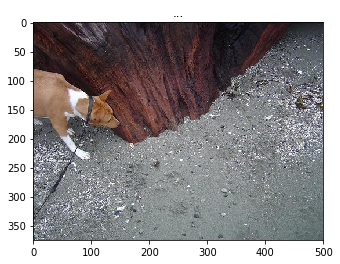

Try another!




In [46]:
for file in np.hstack((human_files[:3], dog_files[:3])):
    run_app(file)